# Q1 Linear Regression

### Imports and Seed

In [302]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.metrics import mean_squared_error

Getting seed

In [303]:
import hashlib
my_seed = int(hashlib.sha256("nidhish.jain".encode()).hexdigest(),16) %(2**32)
print(f"my seed : {my_seed}")

my seed : 3356680259


In [304]:
np.random.seed(my_seed)

getting the student dataset from Q1


In [305]:
class StudentDataset:
    def __init__(self,num_students:int,seed:int):
        self.rng = np.random.default_rng(seed)
        self.total = num_students
        self.df = self.assemble_dataframe()

    def get_full_dataframe(self):
        return self.df #getter?

    def assemble_dataframe(self):
        df = pd.DataFrame({"id": range(1, self.total + 1)})
        df["gender"] = self.generate_gender()
        df["major"] = self.generate_major()
        df["program"] = self.generate_program(df["major"].tolist())
        df["GPA"] = self.generate_gpa(df["major"].tolist())
        return df
    
    def generate_gender(self):
        gender_list = []
        rng = self.rng
        for _ in range(self.total):
            r = rng.random()
            if r < 0.65:
                gender_list.append("Male")
            elif r < 0.65 + 0.33:
                gender_list.append("Female")
            else:
                gender_list.append("Other")
        return gender_list

    def generate_major(self):
        major_list = []
        rng = self.rng
        for _ in range(self.total):
            r = rng.random()
            if r < 0.7:
                major_list.append("B.Tech")
            elif r < 0.7 + 0.2:
                major_list.append("MS")
            else:
                major_list.append("PhD")
        return major_list
    
    def generate_program(self,majors:list[str]):
        program_list = []
        rng = self.rng

        for major in majors:
            if major == "B.Tech":
                program_list.append(rng.choice(["CSE", "ECE", "CHD", "CND"],p=[0.4,0.4,0.1,0.1]))
            elif major == "MS":
                program_list.append(rng.choice(["CSE", "ECE", "CHD", "CND"],p=[0.3,0.3,0.2,0.2]))
            else:
                program_list.append(rng.choice(["CSE", "ECE", "CHD", "CND"])) ## all are same nahi likhuga ;)
        return program_list
    
    def generate_gpa(self,majors:list[str]):
        gpa_list = []
        rng = self.rng
        for major in majors:
            if major == "B.Tech":
                val = rng.normal(7.0,1.0)
                
            elif major == "MS":
                val = rng.normal(8.0,0.7)
            else:
                val = rng.normal(8.3,0.5)
            val = np.clip(val,4.0,10.0)
            gpa_list.append(val)
        return gpa_list 

creating instance of now as per the question will use it

In [306]:
stud_data = StudentDataset(10000,my_seed)
df = stud_data.get_full_dataframe()
df.head()

,id,gender,major,program,GPA
0,1,Male,B.Tech,CSE,8.947960
1,2,Female,B.Tech,ECE,9.653932
2,3,Male,B.Tech,ECE,7.281660
3,4,Male,B.Tech,CSE,6.248276
4,5,Male,PhD,CND,8.913198


In [307]:
class PerFeatureTransformer:
    def __init__(self):
        self.transformers = {}

    def fit(self, df: pd.DataFrame, params: dict[str, str]) :
        feature_name_list = []
        for col, t_type in params.items():
            if t_type == "standard":
                transformer = StandardScaler()
                transformer.fit(df[[col]])
            elif t_type == "ordinal":
                categories = [sorted(df[col].dropna().unique().tolist())]
                transformer = OrdinalEncoder(categories=categories)
                transformer.fit(df[[col]])
            elif t_type == "onehot":
                print(f"col is {col}")
                transformer = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
                transformer.fit(df[[col]])
                arr = transformer.get_feature_names_out([col])
                # arr = arr.to_list()
                feature_name_list.append(arr.tolist())
            self.transformers[col] = (t_type, transformer)
        return [name for group in feature_name_list for name in group]


    def transform(self, df: pd.DataFrame) -> np.ndarray:
        arrays = []
        for col, (t_type, transformer) in self.transformers.items():
            arr = transformer.transform(df[[col]])
            # print(f"ttype : {t_type},shape : {arr.shape}")
            arrays.append(arr)
        return np.hstack(arrays)

    def fit_transform(self, df: pd.DataFrame, params: dict[str, str]) :
        list_name = self.fit(df, params)
        return list_name,self.transform(df)

In [308]:
def train_val_test_split(student_df, test_size: float = 0.2, val_size: float = 0.2, seed: int = 42):
        # First split: separate test set (20%)
        train_val_df, test_df = train_test_split(student_df, test_size=test_size, random_state=seed)
        train_df, val_df = train_test_split(train_val_df, test_size=val_size/(1-test_size), random_state=seed)
        return train_df, val_df, test_df

In [309]:
transformer_obj = PerFeatureTransformer()

In [310]:
train_df, val_df, test_df = train_val_test_split(df, test_size=0.2, val_size=0.2, seed=my_seed)

In [311]:
train_df.head()

,id,gender,major,program,GPA
1236,1237,Female,B.Tech,ECE,6.567598
753,754,Other,B.Tech,CHD,6.387686
9665,9666,Male,B.Tech,ECE,7.001458
200,201,Male,MS,CND,8.281477
7800,7801,Male,B.Tech,CSE,6.804556


In [312]:
val_df.head()

,id,gender,major,program,GPA
9740,9741,Male,B.Tech,CSE,5.571052
464,465,Male,MS,CHD,7.833013
2635,2636,Female,B.Tech,CSE,8.319507
4344,4345,Female,B.Tech,CND,6.455518
7127,7128,Male,B.Tech,ECE,7.743094


In [313]:
test_df.head()

,id,gender,major,program,GPA
2417,2418,Female,PhD,CND,7.620535
6205,6206,Male,B.Tech,CND,7.676731
9537,9538,Male,B.Tech,ECE,7.273368
3389,3390,Male,B.Tech,CSE,7.981971
6068,6069,Male,B.Tech,ECE,6.340239


In [314]:
params = {
    "gender" : "ordinal",
    "major" : "ordinal",
    "program" : "onehot",
}

feature_name,X_train = transformer_obj.fit_transform(train_df,params=params)
y_train = train_df["GPA"].values
# print(X_train[:5])
X_val = transformer_obj.transform(val_df)
y_val = val_df["GPA"].values

X_test = transformer_obj.transform(test_df)
y_test = test_df["GPA"].values

# Create a complete list of feature names matching the transformed data columns
all_feature_names = []
for col, (t_type, transformer) in transformer_obj.transformers.items():
    if t_type == "onehot":
        all_feature_names.extend(transformer.get_feature_names_out([col]))
    else:
        all_feature_names.append(col)

print("One-hot feature names:", feature_name)
print("All feature names:", all_feature_names)
print("Number of columns in X_train:", X_train.shape[1])
print("Number of feature names:", len(all_feature_names))

col is program
One-hot feature names: ['program_CHD', 'program_CND', 'program_CSE', 'program_ECE']
All feature names: ['gender', 'major', 'program_CHD', 'program_CND', 'program_CSE', 'program_ECE']
Number of columns in X_train: 6
Number of feature names: 6


In [315]:
# class Ridge:
#     def __init__(self, alpha: float = 1.0, lr: float = 0.01, max_iter: int = 1000):
#         self.alpha = alpha        # regularization strength
#         self.lr = lr              # learning rate
#         self.max_iters = max_iter
#         self.coef_ = None
#         self.intercept = None

#     def fit(self, X, y):
#         n_samples, n_features = X.shape
#         x_ = np.hstack((np.ones((n_samples, 1)), X))  # Add intercept term
#         w = np.zeros(x_.shape[1])

#         for _ in range(self.max_iters):
#             y_pred = x_.dot(w)
#             gradient = (-2/n_samples) * x_.T.dot(y - y_pred) + 2 * self.alpha * np.r_[0, w[1:]]
#             w -= self.lr * gradient   # ✅ use learning rate here
#         self.intercept = w[0]
#         self.coef_ = w[1:]

#     def predict(self, X):
#         return X @ self.coef_ + self.intercept


In [316]:
# class Lasso:
#     def __init__(self, alpha: float = 0.1, lr: float = 0.01, max_iter: int = 1000):
#         self.alpha = alpha      # regularization strength
#         self.lr = lr            # learning rate
#         self.max_iters = max_iter
#         self.intercept = None
#         self.coef_ = None

#     def fit(self, X, y):
#         n_samples, n_features = X.shape
#         x_ = np.hstack((np.ones((n_samples, 1)), X))  # Add intercept term
#         w = np.zeros(x_.shape[1])

#         for _ in range(self.max_iters):
#             y_pred = x_.dot(w)
#             # Gradient with L1 penalty (skip intercept in penalty)
#             gradient = (-2/n_samples) * x_.T.dot(y - y_pred) + self.alpha * np.r_[0, np.sign(w[1:])]
#             w -= self.lr * gradient  # ✅ use learning rate here
#         self.intercept = w[0]
#         self.coef_ = w[1:]

#     def predict(self, X):
#         return X @ self.coef_ + self.intercept


In [317]:
class PolynomialRegression:

    def _add_watermark(self, ax):
        """Helper to add watermark to a plot."""
        ax.text(0.95, 0.95, "nidhish.jain",
                ha='right', va='top',
                transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)
        
    def run_poly_regression (self, X_train , y_train ,
                                X_val , y_val ,
                                X_test , y_test ,
                                degree =1 ,
                                regularizer = None ,
                                reg_strength =0.0,
                                input_features = None) :
        """
        Fit a polynomial regression model with optional regularization .
        Parameters :
        degree ( int ) : Degree of the polynomial to fit
        regularizer ( str or None ) : ’ l1 ’, ’ l2 ’, or None
        reg_strength ( float ) : Regularization coefficient ( alpha )
        Returns :
        dict with train , val , and test MSEs , and learned
        coefficients
        """
        ###ok lets start 
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly   = poly.transform(X_val)
        X_test_poly  = poly.transform(X_test)
        poly_feature_names = poly.get_feature_names_out(input_features)

        if regularizer is None:
            model = LinearRegression()
        elif regularizer == "l1":
            model = Lasso(alpha=reg_strength,max_iter=1000)
        elif regularizer == "l2":
            model = Ridge(alpha=reg_strength,max_iter=1000)
        model.fit(X_train_poly, y_train)

        y_train_pred = model.predict(X_train_poly)
        y_val_pred = model.predict(X_val_poly)
        y_test_pred = model.predict(X_test_poly)

        train_mse = mean_squared_error(y_train, y_train_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        return {
            "train_mse": train_mse,
            "val_mse": val_mse,
            "test_mse": test_mse,
            "coefficients": dict(zip(poly_feature_names, model.coef_)),
        }
    

    def plot_mse_vs_deg(self,degrees, mse_train,mse_val,reuglatizer):
        plt.figure(figsize=(10,6))
        plt.plot(degrees, mse_train, label='Train MSE', marker='o')
        plt.plot(degrees, mse_val, label='Validation MSE', marker='o')
        plt.xlabel('Polynomial Degree')
        plt.ylabel('Mean Squared Error')
        plt.title(f'MSE vs Polynomial Degree ({reuglatizer})')
        plt.legend()
        plt.grid()
        self._add_watermark(plt.gca())
        plt.show()

    def plot_val_mse_reg_stren(self,reg_strength,mse_val):
        plt.figure(figsize=(10,6))
        plt.plot(reg_strength, mse_val, label='Validation MSE', marker='o')
        plt.xlabel('Regularization Strength')
        plt.ylabel('Mean Squared Error')
        plt.title('Validation MSE vs Regularization Strength')
        plt.legend()
        plt.grid()
        self._add_watermark(plt.gca())
        plt.show()

In [318]:
Poly_obj = PolynomialRegression()

In [319]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())
print(np.isnan(X_val).sum(), np.isnan(y_val).sum())
print(np.isnan(X_test).sum(), np.isnan(y_test).sum())

0 0
0 0
0 0


In [320]:
regularizer = [None, 'l1', 'l2']
degree = [1,2,3,4,5,6]
### we will store for each regularizer and then in new cells I will use the plots 

## will be trying this for alpha   =0.1
final = {}
for reg in regularizer:
    val_mse_list = []
    train_mse_list = []
    for deg in degree:
        results = Poly_obj.run_poly_regression (X_train , y_train ,
                                    X_val , y_val ,
                                    X_test , y_test ,
                                    degree =deg ,
                                    regularizer = reg ,
                                    reg_strength =0.1,
                                    input_features=all_feature_names)
        # print(results)
        val_mse_list.append(results['val_mse'])
        train_mse_list.append(results['train_mse'])
    final[reg] = {
        "val_mse": val_mse_list,
        "train_mse": train_mse_list
    }

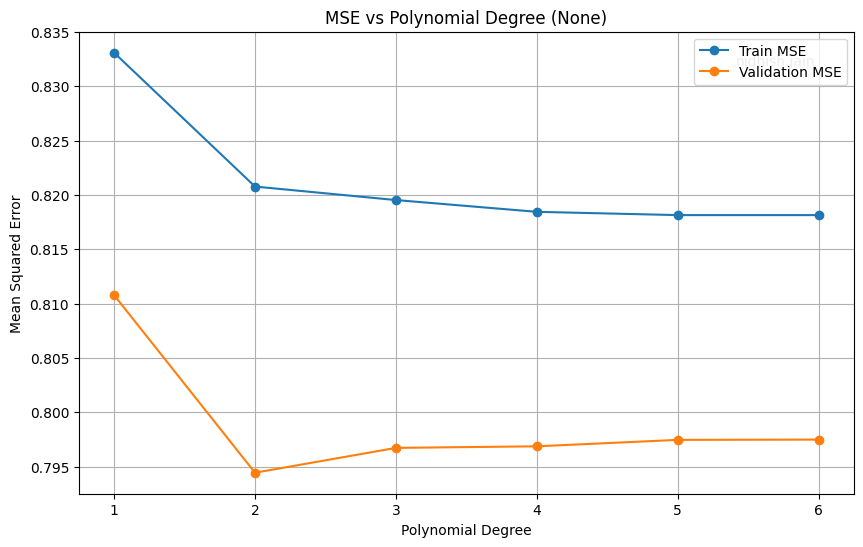

In [321]:
Poly_obj.plot_mse_vs_deg(degree, final[None]['train_mse'], final[None]['val_mse'],None)

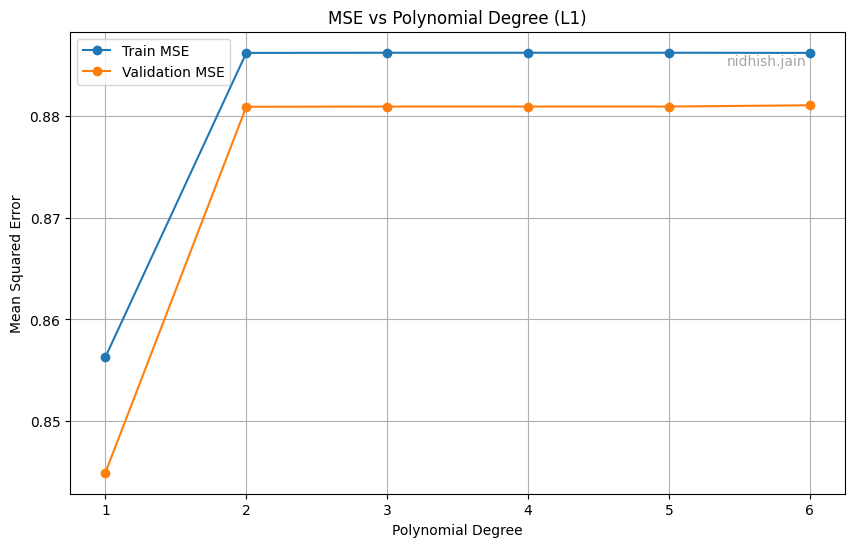

In [322]:
Poly_obj.plot_mse_vs_deg(degree, final['l1']['train_mse'], final['l1']['val_mse'],'L1')

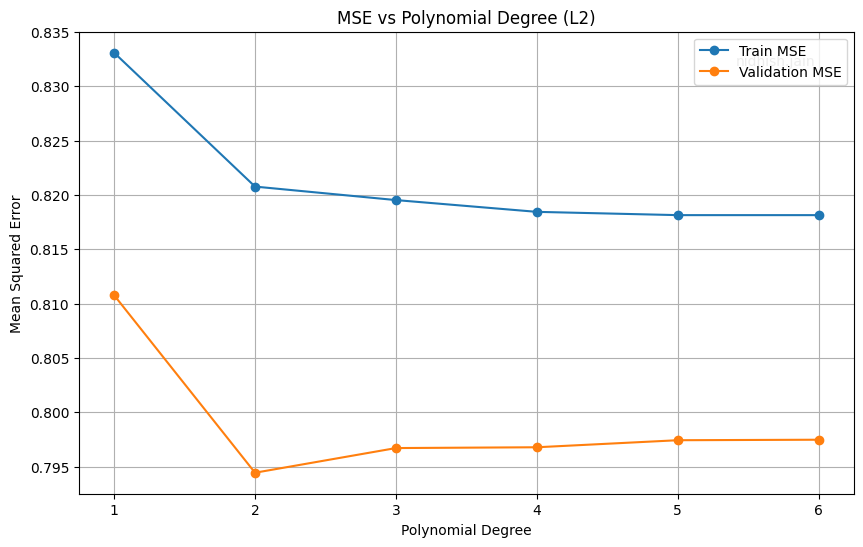

In [323]:
Poly_obj.plot_mse_vs_deg(degree, final['l2']['train_mse'], final['l2']['val_mse'],'L2')


However one thing which is very strange being observed is that the mse values in train is more than mse values in val which is not expected as ideally train mse should be less than val mse as the model is trained on train data and it should perform better on train data than val data. One reason can be that the dataset is random so in reality we might not be able to fit any polynomial in this. Ideally I feel we should have all the features as one hot only as they all are in the end categorical features.

Reason for this I only find is that my seed is weird when I tried with a different seed it went for the ideal results which are expected so nothing can be done.

In [324]:
alpha_vals = np.logspace(-4, 4, 10)
print(alpha_vals)

[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


--- Best Model (No Regularization) ---
Best Degree: 2, Val MSE: 0.7944



/home/nidhishjain/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.591e+02, tolerance: 6.422e-01
  model = cd_fast.enet_coordinate_descent(
/home/nidhishjain/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.664e+02, tolerance: 6.422e-01
  model = cd_fast.enet_coordinate_descent(
/home/nidhishjain/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

--- Best Model (L1 Regularization) ---
Best Degree: 2, Best Alpha: 0.000774263682681127, Val MSE: 0.7939

--- Best Model (L2 Regularization) ---
Best Degree: 2, Best Alpha: 0.0001, Val MSE: 0.7944



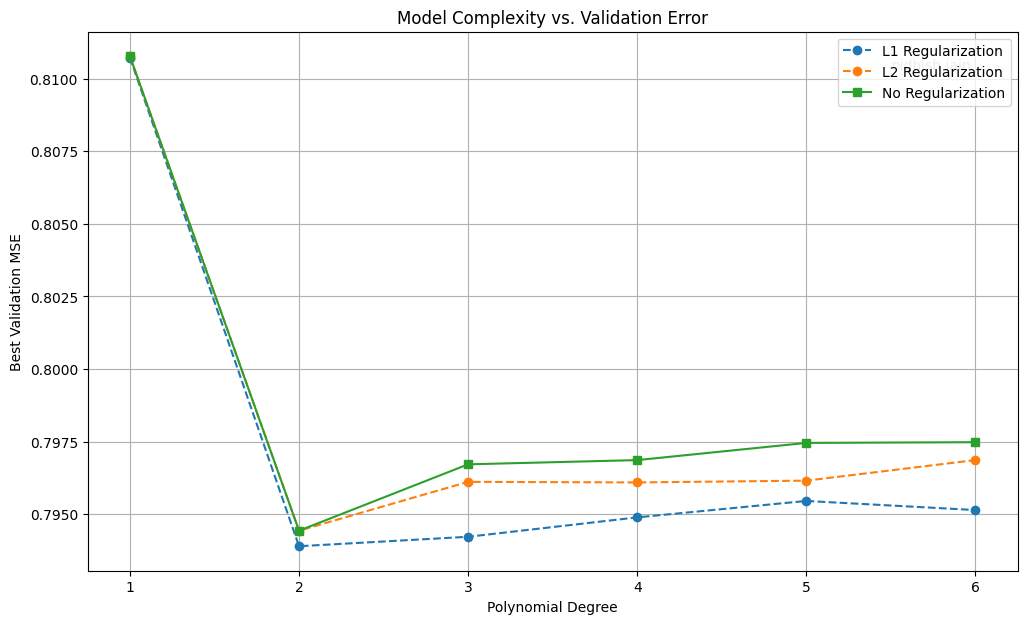

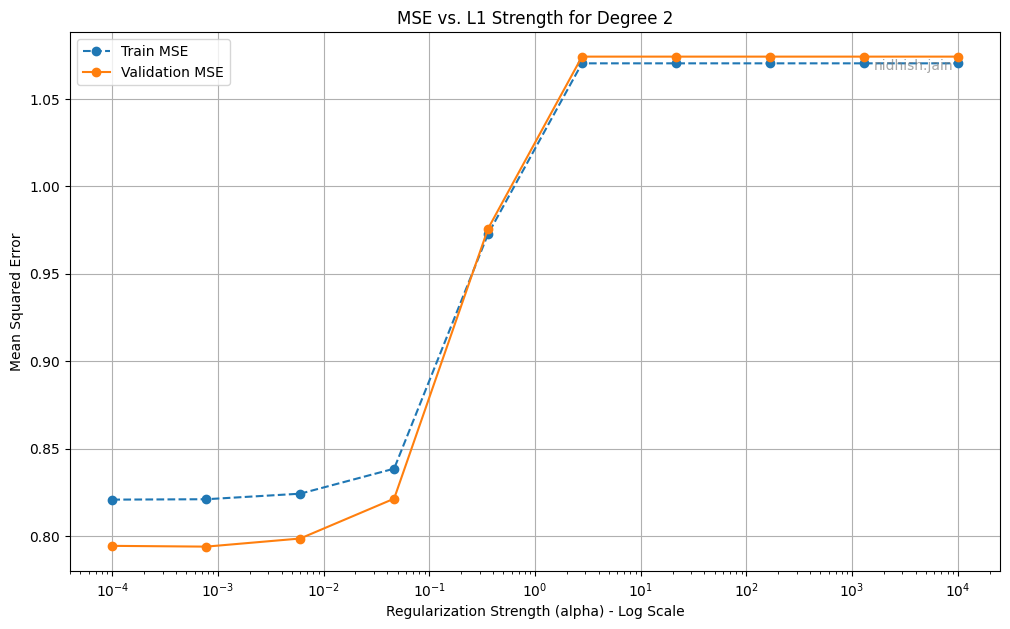

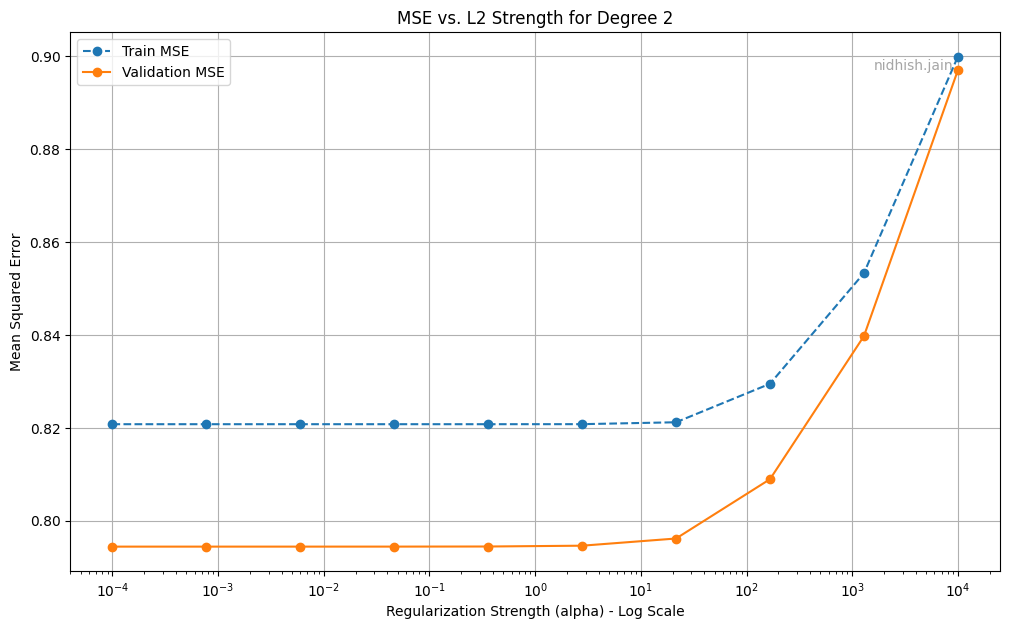

In [325]:

# Assume Poly_obj, X_train, y_train, etc., are already defined# Assume regularizer = [None, 'l1', 'l2'], degrees = [...], alpha_vals = [...]

# This dictionary will store every single result, which is a great practice.
all_run_results = {}
# This will store the final summary for the best model of each type.
final_summary = {}

# --- Step 1: Find the best model without regularization ---
if None in regularizer:
    results_no_reg = []
    for deg in degree:
        # For 'None' case, alpha is irrelevant, but we can use 0 for consistency
        result = Poly_obj.run_poly_regression(
            X_train, y_train, X_val, y_val, X_test, y_test,
            degree=deg, regularizer=None, reg_strength=0.0
        )
        all_run_results[(None, deg, 0.0)] = result
        results_no_reg.append({'degree': deg, 'val_mse': result['val_mse'], 'train_mse': result['train_mse']})

    # Find the best degree based on validation MSE
    best_degree_info = min(results_no_reg, key=lambda x: x['val_mse'])
    final_summary[None] = best_degree_info
    print("--- Best Model (No Regularization) ---")
    print(f"Best Degree: {best_degree_info['degree']}, Val MSE: {best_degree_info['val_mse']:.4f}\n")


# --- Step 2: Find the best model for L1 and L2 regularization ---
for reg in ['l1', 'l2']:
    if reg not in regularizer:
        continue

    best_results_per_degree = []
    for deg in degree:
        mses_for_current_degree = []
        for alpha in alpha_vals:
            result = Poly_obj.run_poly_regression(
                X_train, y_train, X_val, y_val, X_test, y_test,
                degree=deg, regularizer=reg, reg_strength=alpha
            )
            all_run_results[(reg, deg, alpha)] = result
            mses_for_current_degree.append({'alpha': alpha, 'val_mse': result['val_mse'], 'train_mse': result['train_mse']})
        
        # For the current degree, find the best alpha
        best_alpha_info = min(mses_for_current_degree, key=lambda x: x['val_mse'])
        best_results_per_degree.append({
            'degree': deg,
            'best_alpha': best_alpha_info['alpha'],
            'val_mse': best_alpha_info['val_mse'],
            'train_mse': best_alpha_info['train_mse']
        })

    # Now, find the overall best degree for this regularizer
    best_overall_info = min(best_results_per_degree, key=lambda x: x['val_mse'])
    final_summary[reg] = {
        'best_degree': best_overall_info['degree'],
        'best_alpha': best_overall_info['best_alpha'],
        'val_mse': best_overall_info['val_mse'],
        'train_mse': best_overall_info['train_mse'],
        'all_degrees_summary': best_results_per_degree # Store for plotting
    }
    print(f"--- Best Model ({reg.upper()} Regularization) ---")
    print(f"Best Degree: {final_summary[reg]['best_degree']}, Best Alpha: {final_summary[reg]['best_alpha']}, Val MSE: {final_summary[reg]['val_mse']:.4f}\n")


# --- Step 3: Generate the Plots ---

# Plot 1: Validation MSE vs. Degree (using the best alpha for each degree)
plt.figure(figsize=(12, 7))
for reg in ['l1', 'l2']:
    if reg in final_summary:
        summary = final_summary[reg]['all_degrees_summary']
        degs = [s['degree'] for s in summary]
        mses = [s['val_mse'] for s in summary]
        plt.plot(degs, mses, marker='o', linestyle='--', label=f'{reg.upper()} Regularization')

# Add the 'None' case to the same plot
if None in final_summary:
    degs = [s['degree'] for s in results_no_reg]
    mses = [s['val_mse'] for s in results_no_reg]
    plt.plot(degs, mses, marker='s', linestyle='-', label='No Regularization')

plt.xlabel('Polynomial Degree')
plt.ylabel('Best Validation MSE')
plt.title('Model Complexity vs. Validation Error')
plt.legend()
plt.grid(True)
Poly_obj._add_watermark(plt.gca())
plt.show()


# Plot 2: MSE vs. Regularization Strength (for the single best degree of each regularizer)
for reg in ['l1', 'l2']:
    if reg in final_summary:
        best_deg = final_summary[reg]['best_degree']
        
        # Retrieve all MSEs for this specific degree across all alphas
        val_mses = [all_run_results[(reg, best_deg, alpha)]['val_mse'] for alpha in alpha_vals]
        train_mses = [all_run_results[(reg, best_deg, alpha)]['train_mse'] for alpha in alpha_vals]

        plt.figure(figsize=(12, 7))
        plt.plot(alpha_vals, train_mses, marker='o', linestyle='--', label='Train MSE')
        plt.plot(alpha_vals, val_mses, marker='o', linestyle='-', label='Validation MSE')
        plt.xscale('log') # Use a logarithmic scale for alpha
        plt.xlabel('Regularization Strength (alpha) - Log Scale')
        plt.ylabel('Mean Squared Error')
        plt.title(f'MSE vs. {reg.upper()} Strength for Degree {best_deg}')
        plt.legend()
        plt.grid(True)
        Poly_obj._add_watermark(plt.gca())
        plt.show()

as our alpha is increasing we can see here that the val mse is increasing the model is getting overfitted due to increase in alpha so we have to choose a lower alpha value

In [326]:
# This loop to find the best model is correct
best_val_mse = float('inf')
best_model_info = None
for key, result in all_run_results.items():
    if result['val_mse'] < best_val_mse:
        best_val_mse = result['val_mse']
        best_model_info = (key, result)

# --- Improved Printing Section ---

# Unpack the key and result for clarity
best_key, best_result_dict = best_model_info
reg_type, degree, alpha = best_key

print("--- Overall Best Model ---")
print(f"Regularizer: {reg_type}")
print(f"Polynomial Degree: {degree}")
print(f"Regularization Strength (Alpha): {alpha}")
print("-" * 28)
# It's good practice to report the test MSE for the final chosen model
print(f"Validation MSE: {best_result_dict['val_mse']:.4f}")
print(f"Test MSE: {best_result_dict['test_mse']:.4f}")
print(f"Train MSE: {best_result_dict['train_mse']:.4f}")

# Loop through the coefficients dictionary for a clean output

--- Overall Best Model ---
Regularizer: l1
Polynomial Degree: 2
Regularization Strength (Alpha): 0.000774263682681127
----------------------------
Validation MSE: 0.7939
Test MSE: 0.8289
Train MSE: 0.8210


Clearly there is a improvement in accuracy when we use regularization as the best model which we are getting is when we have l1 regularization.

Reason L1 and L2 both reduces the overfitting so for higher degree polynomial we can reduce the coefficietns of higher degree.

In [327]:
# --- Part 1: Analyze the Best L1 (Lasso) Model ---

# Check if an L1 model was successfully found
if 'l1' in final_summary:
    # Get the hyperparameters of the best L1 model
    best_l1_degree = final_summary['l1']['best_degree']
    best_l1_alpha = final_summary['l1']['best_alpha']
    
    # Create the key to look up the full results
    l1_key = ('l1', best_l1_degree, best_l1_alpha)
    
    # Retrieve the coefficients
    l1_coeffs = all_run_results[l1_key]['coefficients']
    
    # Filter for features with non-zero weights
    l1_nonzero_coeffs = {feature: coeff for feature, coeff in l1_coeffs.items() if abs(coeff) > 1e-6}
    
    # Sort the non-zero features by the absolute magnitude of their weights
    l1_sorted_coeffs = sorted(l1_nonzero_coeffs.items(), key=lambda item: abs(item[1]), reverse=True)
    
    print("---  Best L1 (Lasso) Model Analysis ---")
    print(f"Found {len(l1_sorted_coeffs)} non-zero features out of {len(l1_coeffs)} total features.\n")
    print("Most Important Predictors for GPA (L1):")
    # Print the top 10 most important features
    for feature, coeff in l1_sorted_coeffs[:10]:
        print(f"  - {feature}: {coeff:.4f}")
else:
    print("No L1 model summary found.")

print("\n" + "="*50 + "\n")

# --- Part 2: Analyze the Best L2 (Ridge) Model ---

# Check if an L2 model was successfully found
if 'l2' in final_summary:
    # Get the hyperparameters of the best L2 model
    best_l2_degree = final_summary['l2']['best_degree']
    best_l2_alpha = final_summary['l2']['best_alpha']

    # Create the key
    l2_key = ('l2', best_l2_degree, best_l2_alpha)

    # Retrieve the coefficients
    l2_coeffs = all_run_results[l2_key]['coefficients']
    
    # For L2, all weights will be non-zero, so we just sort them by magnitude
    l2_sorted_coeffs = sorted(l2_coeffs.items(), key=lambda item: abs(item[1]), reverse=True)

    print("---  Best L2 (Ridge) Model Analysis ---")
    print(f"All {len(l2_sorted_coeffs)} features have non-zero weights.\n")
    print("Most Important Predictors for GPA (L2):")
    # Print the top 10 most important features
    for feature, coeff in l2_sorted_coeffs[:10]:
        print(f"  - {feature}: {coeff:.4f}")
else:
    print("No L2 model summary found.")

---  Best L1 (Lasso) Model Analysis ---
Found 10 non-zero features out of 27 total features.

Most Important Predictors for GPA (L1):
  - x1: 1.2182
  - x1^2: -0.2846
  - x0: -0.1052
  - x0^2: 0.0644
  - x1 x3: 0.0291
  - x0 x2: -0.0190
  - x4^2: -0.0170
  - x1 x2: -0.0133
  - x0 x3: -0.0115
  - x1 x5: 0.0028


---  Best L2 (Ridge) Model Analysis ---
All 27 features have non-zero weights.

Most Important Predictors for GPA (L2):
  - x1: 0.9939
  - x1^2: -0.3007
  - x1 x3: 0.2795
  - x1 x5: 0.2520
  - x1 x4: 0.2454
  - x1 x2: 0.2170
  - x0: -0.1282
  - x0^2: 0.0875
  - x0 x2: -0.0690
  - x0 x3: -0.0598


In L1 Regularization we will observe that features will have 0 weights for higher degrees as the model is getting overfitted and l1 regularization will try to reduce the weights of features to 0 to reduce the complexity of model. But in L2 regularization we will observe that weights will be very small but not 0 as l2 regularization will try to reduce the weights but not make them 0. 

Reason being the way the regularizer terms are defined.

L1 regularization - sum of the absolute values of the coefficients multiplied by alpha so this will make some of the weights 0 to reduce the complexity of model.

In L2 regularization - sum of the squares of the coefficients multiplied by alpha so this will make the weights very small but not 0 as squaring a number will always give a positive value and it will not be 0 unless the weight itself is 0 which is not possible as l2 regularization will try to reduce the weights but not make them 0.